# Internal control experiments

This notebooks runs some experiments with internal bandit NRM control. 

For the application of the NRM model to resource management to one
computational job, the global resource optimization problem is the following:

$$
\begin{array}{l}
    \min \quad e_{\text{total}} \\
	\text{s.t.} \quad  t > \tau t_{\text{ref}}
\end{array}
$$

Where $e_{\text{total}}$ denotes the total energy spent by the system during
the lifetime of the job, whose duration is denoted by $t^T$. We denote by
$t_{\text{ref}}$ a reference measurement of the runtime of the job on an
unmanaged system. $\tau <1$ is a parameter controlling the amount of runtime
degradation allowed for the job.

The value of this global objective can be easily measured a-posteriori for a
computational job using power instrumentation techniques. Assuming both
workload and platform behavior to be deterministic, this objective is measured
using two runs of the system: A first run without resource management to
acquire $t_{\text{ref}}$, and one run with NRM enabled. In order for NRM's
round-based control strategy to address this problem, we need an online loss
value however. This loss is obtained using the following loose assumptions:

- The passive power consumption of the node is fixed and known. [1]

- The total power consumption in a given time period can be estimated as
  the sum of the static node consumption over that period and the RAPL power
  measurement over that period. [2]

- The impact of a choice of power-cap on the job's runtime can be
  interpolated linearly from its impact on CPU counters. [3]


Denoting as in the previous section the round counter by $0<r<T$, the known
passive static power consumption by $p_{\text{static}}$, the starting time of
the job by $t^0$ and the end time of round $r$ by $t^r$, we can write the total
energy expenditure of the job based on RAPL power measurements $p^r$ using
assumptions 1 and 2 as:

$$
	e_{\text{total}} = \sum_{r=1}^{r=T} (p^r + p_{\text{static}}) (t^{r-1} - t^{r})
$$

Using assumption 3 means that we can reasonably estimate the
change in job runtime incurred by the choice of power-cap in round $r$ by
evaluating $\frac{s^r_{\text{ref}}}{s^r}$. We use this as part of our proxy
cost in two ways. First, this quantity is used to evaluate breaching of the
constraint on $t$, and second, it is used to adjust for an expected increase in
the number of rounds due to the impact on job runtime. This gives rise to the
following value for the loss at round $r$:

$$
	\ell^r = \mathbb{\huge 1}_{\left( \frac{s^r}{s^r_{\text{ref}}}>\tau \right)}
   \left( \frac{s^r_{\text{ref}}}{s^r} \left( p^r + p_{\text{static}} \right) \right)
$$


In [1]:
cd ..

/home/fre/workspace/hnrm


In [2]:
%%capture
%%bashtt
./shake.sh build # for the daemon 
./shake.sh client # for the upstream client
./shake.sh pyclient # for the shared client library

In [20]:
%load_ext nb_black
import json

daemonCfgs = {
    "controlOn": {
        "controlCfg": {
            "staticPower": {"fromuW": 200000000},
            "referenceMeasurementRoundInterval": 10,
            "learnCfg": {"lagrangeConstraint": 1},
            "speedThreshold": 0.9,
            "minimumControlInterval": {"fromuS": 1000000},
        },
        "verbose": "Debug",
    },
    "pcapMax": {},
}


def perfwrapped(cmd, args):
    return [
        {
            "cmd": cmd,
            "args": args,
            "sliceID": "toto",
            "manifest": {
                "app": {
                    "slice": {"cpus": 1, "mems": 1},
                    "perfwrapper": {
                        "perfLimit": {"fromOps": 100000},
                        "perfFreq": {"fromHz": 1},
                    },
                },
                "name": "perfwrap",
            },
        }
    ]


stream = perfwrapped("stream_c", [])
lammps = perfwrapped(
    "mpiexec",
    ["-n", "24", "amg", "-problem", "2", "-n", "90", "90", "90", "-P", "2", "12", "1"],
)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [21]:
import nrm.tooling as nrm

host = nrm.Local()

<IPython.core.display.Javascript object>

In [22]:
host.start_daemon(daemonCfgs["pcapMax"])
assert host.check_daemon()
print(host.get_cpd())

connecting
connected to tcp://localhost:2345
Pretty-printing the control problem description:
 Problem 
    { sensors = Map 
        [ 
            ( SensorID { sensorID = "RaplKey (PackageID 0)" }
            , Sensor 
                { range = 0.0 ... 300.0
                , maxFrequency = 3.0
                } 
            ) 
        ]
    , actuators = Map 
        [ 
            ( ActuatorID { actuatorID = "RaplKey (PackageID 0)" }
            , Actuator 
                { actions = 
                    [ DiscreteDouble 100.0
                    , DiscreteDouble 200.0
                    ] 
                }
            ) 
        ]
    , objectives = []
    , constraints = []
    } 
Python dictionary version: {'objectives': [], 'constraints': [], 'sensors': [['RaplKey (PackageID 0)', {'maxFrequency': 3, 'range': {'i': [0, 300]}}]], 'actuators': [['RaplKey (PackageID 0)', {'actions': [100, 200]}]]}


<IPython.core.display.Javascript object>

The next cell just stops the daemon cleanly.

In [23]:
host.stop_daemon()
assert host.check_daemon() == False

<IPython.core.display.Javascript object>

### Helpers

For performing experiments:

In [30]:
import time
from collections import defaultdict


def do_workload(host, daemonCfg, workload):
    host.start_daemon(daemonCfg)
    print("Starting the workload")
    host.run_workload(workload)
    history = defaultdict(list)
    # print(host.get_state())
    getCPD = True
    try:
        while host.check_daemon() and not host.workload_finished():
            measurement_message = host.workload_recv()
            msg = json.loads(measurement_message)
            if "pubMeasurements" in msg:
                if getCPD:
                    getCPD = False
                    time.sleep(3)
                    cpd = host.get_cpd()
                    print(cpd)
                    cpd = dict(cpd)
                    print("Sensor identifier list:")
                    for sensorID in [sensor[0] for sensor in cpd["sensors"]]:
                        print("- %s" % sensorID)
                    print("Actuator identifier list:")
                    for sensorID in [sensor[0] for sensor in cpd["actuators"]]:
                        print("- %s" % sensorID)
                content = msg["pubMeasurements"][1][0]
                t = content["time"]
                sensorID = content["sensorID"]
                x = content["sensorValue"]
                print(
                    ".",
                    end=""
                    # "Measurement: originating at time %s for sensor %s of value %s"
                    #% (content["time"], content["sensorID"], content["sensorValue"])
                )
                history["sensor-" + sensorID].append((t, x))
            if "pubCPD" in msg:
                print("R")
            if "pubAction" in msg:
                # print(host.get_state())
                # print(msg)
                t, contents, meta, controller = msg["pubAction"]
                if "bandit" in controller.keys():
                    for key in meta.keys():
                        history["actionType"].append((t, key))
                    if "referenceMeasurementDecision" in meta.keys():
                        print("a:reference")
                    elif "initialDecision" in meta.keys():
                        print("a:initial decision")
                    elif "innerDecision" in meta.keys():
                        print("a:inner")
                        counter = 0
                        for value in meta["innerDecision"]["constraints"]:
                            history["constraint-" + str(counter)].append(
                                (t, value["fromConstraintValue"])
                            )
                            counter = counter + 1
                        counter = 0
                        for value in meta["innerDecision"]["objectives"]:
                            history["objective-" + str(counter)].append(
                                (t, value["fromObjectiveValue"])
                            )
                            counter = counter + 1
                        history["reward"] = history["reward"].append(
                            meta["innerDecision"]["reward"]
                        )
                for content in contents:
                    actuatorID = content["actuatorID"] + "(action)"
                    x = content["actuatorValue"]
                    history[actuatorID].append((t, x))
                    for arm in controller["bandit"]["lagrange"]["lagrangeConstraint"][
                        "weights"
                    ]:
                        value = arm["action"][0]["actuatorValue"]
                        history[str(value / 1000000) + "-probability"].append(
                            (t, arm["probability"]["getProbability"])
                        )
                        history[str(value / 1000000) + "-cumulativeLoss"].append(
                            (t, arm["cumulativeLoss"]["getCumulativeLoss"])
                        )
                # print(
                # "Action: originating at time %s for actuator %s of value %s"
                #% (t,actuatorID,x)
                # )
            host.check_daemon()
    except:
        return history
    host.stop_daemon()
    return history

<IPython.core.display.Javascript object>

For plotting:

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_history(history, nplots):
    fig = plt.figure()
    fig, (axes) = plt.subplots(nplots, 1, sharex=True)
    fig.subplots_adjust(wspace=0.1)
    fig.set_size_inches(17, 25 * nplots / 10, forward=True)

    minTime = min(
        [
            min([pd.Timestamp(m[0], unit="us") for m in measurements])
            for cname, measurements in history.items()
        ]
    )
    maxTime = max(
        [
            max([pd.Timestamp(m[0], unit="us") for m in measurements])
            for cname, measurements in history.items()
        ]
    )

    plt.xlim(minTime, maxTime)

    for ((columnName, measurements), ax) in zip(history.items(), axes):
        ax.set_title(columnName)
        dataframe = pd.DataFrame(
            data=[(pd.Timestamp(t, unit="us"), m) for t, m in measurements]
        )
        dataframe.columns = ["time", "value"]
        if dataframe.dtypes["value"] == "object":
            sns.catplot(ax=ax, x="time", y="value", kind="swarm", data=dataframe)
        else:
            sns.scatterplot(ax=ax, x="time", y="value", data=dataframe)
    return (minTime, maxTime)

<IPython.core.display.Javascript object>

In [34]:
history_pcapMax = do_workload(host, daemonCfgs["pcapMax"], stream)

connecting
connected to tcp://localhost:2345
Starting the workload


<IPython.core.display.Javascript object>

Runtime: 0 days 00:01:44.000545


<Figure size 432x288 with 0 Axes>

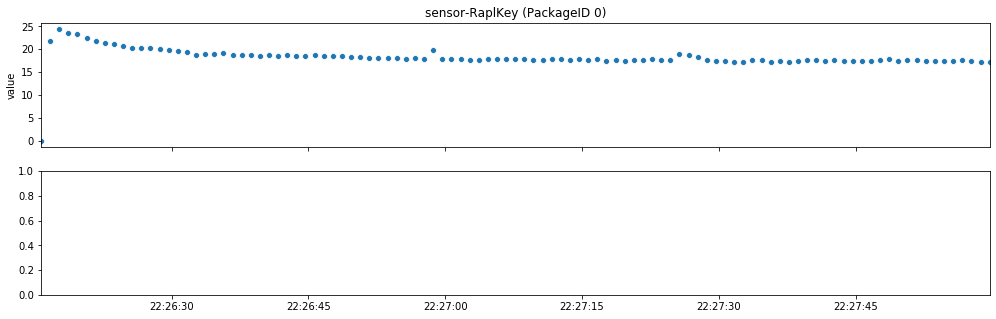

<IPython.core.display.Javascript object>

In [28]:
t_min_pMax, t_max_pMax = plot_history(history_pcapMax, 2)
runtime = t_max_pMax - t_min_pMax
print("Runtime: %s" % runtime)

In [36]:
history_controlOn = do_workload(host, daemonCfgs["controlOn"], stream)

connecting
connected to tcp://localhost:2345
Starting the workload
Problem 
    { sensors = Map 
        [ 
            ( SensorID { sensorID = "RaplKey (PackageID 0)" }
            , Sensor 
                { range = 0.0 ... 300.0
                , maxFrequency = 3.0
                } 
            ) 
        ]
    , actuators = Map 
        [ 
            ( ActuatorID { actuatorID = "RaplKey (PackageID 0)" }
            , Actuator 
                { actions = 
                    [ DiscreteDouble 100.0
                    , DiscreteDouble 200.0
                    ] 
                }
            ) 
        ]
    , objectives = 
        [ 
            ( 1.0
            , OAdd 
                ( OValue 
                    ( SensorID { sensorID = "RaplKey (PackageID 0)" } )
                ) ( OScalar 200.0 )
            ) 
        ]
    , constraints = []
    } 
Sensor identifier list:
- RaplKey (PackageID 0)
Actuator identifier list:
- RaplKey (PackageID 0)
..................

<IPython.core.display.Javascript object>

In [19]:
plot_history(history_controlOn,11)

NameError: name 'history_controlOn' is not defined

<IPython.core.display.Javascript object>